In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


**Importing necessary files and tokenizing dataset**

In [4]:
train_dataset=pd.read_csv('/kaggle/input/ag-news-dataset/ANLP-2/train.csv')
test_dataset=pd.read_csv('/kaggle/input/ag-news-dataset/ANLP-2/test.csv')

In [5]:
def removealphanumeric(string):
    string=re.sub('[^a-zA-Z0-9]',' ',string)
    return(string)

In [6]:
train_dataset[train_dataset.columns[1]]=train_dataset[train_dataset.columns[1]].apply(lambda i:removealphanumeric(i))
test_dataset[test_dataset.columns[1]]=test_dataset[test_dataset.columns[1]].apply(lambda i:removealphanumeric(i))

In [7]:
train_dataset.head()

,Class Index,Description
0,3,Reuters Short sellers Wall Street s dwindli...
1,3,Reuters Private investment firm Carlyle Grou...
2,3,Reuters Soaring crude prices plus worries ab...
3,3,Reuters Authorities have halted oil export f...
4,3,AFP Tearaway world oil prices toppling reco...


In [8]:
mxlen=[]
for column in train_dataset[train_dataset.columns[1]]:
    mxlen.append(len(column))

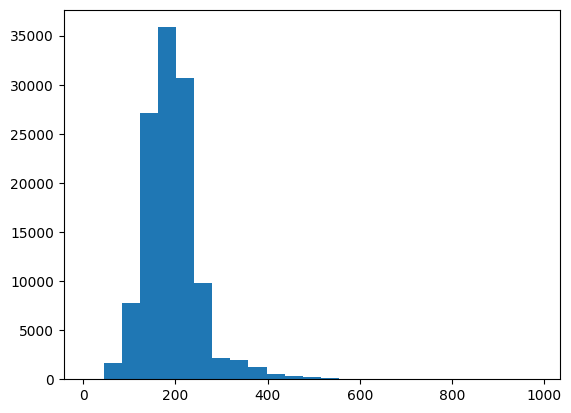

In [9]:
import matplotlib.pyplot as plt
z=plt.hist(mxlen,bins=25)

Since Most of the prob. lies in the first 3 Bins that are of length until 350 so we take the mxlen of 500

In [10]:
z

(array([5.2000e+01, 1.6450e+03, 7.8180e+03, 2.7161e+04, 3.5846e+04,
        3.0683e+04, 9.7640e+03, 2.1910e+03, 1.9920e+03, 1.2390e+03,
        5.5500e+02, 3.5800e+02, 2.5800e+02, 1.3100e+02, 6.4000e+01,
        5.2000e+01, 2.7000e+01, 7.8000e+01, 1.3000e+01, 1.3000e+01,
        1.5000e+01, 1.0000e+01, 8.0000e+00, 1.7000e+01, 1.0000e+01]),
 array([  6.  ,  45.16,  84.32, 123.48, 162.64, 201.8 , 240.96, 280.12,
        319.28, 358.44, 397.6 , 436.76, 475.92, 515.08, 554.24, 593.4 ,
        632.56, 671.72, 710.88, 750.04, 789.2 , 828.36, 867.52, 906.68,
        945.84, 985.  ]),
 <BarContainer object of 25 artists>)

Initial Vocab from file


In [11]:
word_to_ix={}
ix_to_word={}

In [12]:
word_to_ix['<UNK>']=1
word_to_ix['<PAD>']=0
ix_to_word[1]='<UNK>'
ix_to_word[0]='<PAD>'

In [13]:
tok=[]
for x in tqdm(train_dataset[train_dataset.columns[1]]):
    x=x.strip()
    if len(x)==0 or x[0]=='=':continue
    tok+=[w for w in x.split(' ')]

100%|██████████| 120000/120000 [00:00<00:00, 150409.18it/s]


In [14]:
for idx,word in  enumerate(set(tok)):
    word_to_ix[word]=idx+2
    ix_to_word[idx+2]=word

**Creating Dataset and DataLoader for the model training and testing**

In [15]:
class Datafetch(Dataset):
    def __init__(self,split):
        data=[]
        labels=[]
        for x in tqdm(split[split.columns[1]],desc='Generate next word prediction data'):
            if len(x)<1 or x[0]=='=':continue
            #words=x.strip().split(' ')
            indices=[word_to_ix.get(word,1) for word in x]
            if len(indices)<370:
                indices=indices+(370-len(indices))*[0]
            elif len(indices)>370:
                indices=indices[:370]
            lb_indices=[word_to_ix.get(word,1) for word in x[1:]]
            if len(lb_indices)<370:
                lb_indices=lb_indices+(370-len(lb_indices))*[0]
            elif len(lb_indices)>370:
                lb_indices=lb_indices[:370]
            data.append(indices)
            labels.append(lb_indices)
            #for i in range(len(indices)-1):
             #   ngrams.append(indices[0:i+1]+(max(mxlen)-len(indices[0:i+1]))*[self.vocab['<PAD>']])
              #  next_word.append(indices[i+1])
            #ngrams.append((max(mxlen)-len(indices)+1)*[vocac['<PAD>']]+indices[:-1])
            #next_word.append(indices[-1])
        #max_seq_len=max([len(ngram) for ngram in ngrams])

        self.data=tensor(data)
        #self.ngrams.to(device)
        self.labels=tensor(labels)
        #self.next_word.to(device)
    def __len__(self)->int:
        return len(self.data)
    def __getitem__(self,index:int):
        return self.data[index],self.labels[index]

In [16]:
import gc
torch.cuda.empty_cache()
gc.collect()

30

In [17]:
train_dataset_for_lstm_prediction=train_dataset

In [18]:
train_dataset_with_dataloader_type=Datafetch(train_dataset_for_lstm_prediction)

Generate next word prediction data: 100%|██████████| 120000/120000 [00:08<00:00, 13946.03it/s]


In [19]:
train_dataloader=DataLoader(train_dataset_with_dataloader_type,batch_size=32,shuffle=True,pin_memory=True)

In [20]:
data,labels=next(iter(train_dataloader))

In [21]:
data.shape

torch.Size([32, 370])

In [22]:
labels.shape

torch.Size([32, 370])

In [23]:
print(data[1],labels[1])

tensor([71209, 69991, 22269,     1,    70, 12214, 16894,  6535, 63373, 56661,
        16894, 56661, 23092, 58932, 35404,     1, 17050, 16894, 17317, 22269,
        50546,     1, 24585, 58932, 35404, 50546, 58932, 12214, 22269,     1,
        24585, 58932, 42445, 12214, 31457,     1, 40100, 22269,     1, 31457,
        22269, 37608, 22269, 12214, 58932,  2952, 22269, 31457,     1, 23092,
        35404, 56661, 58932,     1, 16894,     1, 12214, 22269, 16894, 49735,
        35404, 23092, 35404, 17050,     1, 56661, 58932, 58932, 12214,     1,
        15513, 58932, 49735,     1, 24585, 69991, 23092, 12214, 31457, 49735,
        22269, 35404,     1,     1, 50546, 16894,  6535, 50546,     1, 16894,
            1, 45290, 58932, 49735, 56661, 69991, 42445, 17317, 40100, 22269,
        49735, 12214, 16894, 35404, 31457,     1, 69991, 22269, 16894, 31457,
            1, 56661, 22269, 16894, 24585, 69991, 22269, 49735,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

**Creating ELMO architecture as appeared in the paper with some small modifications where hyperparams are changed**

In [24]:
class ElmoProcessor(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim):
        super(ElmoProcessor,self).__init__()
        self.embeddings=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.lstmf1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmf2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        #self.embedding=wt_mat.to(device)
        self.lstmb1=nn.LSTM(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.lstmb2=nn.LSTM(hidden_dim,hidden_size=hidden_dim,bidirectional=False,batch_first=True)
        #self.lstm1.weight=nn.Parameter(self.lstm1.weight,requires_grad=True)
        #self.lstm2.weight=nn.Parameter(self.lstm2.weight,requires_grad=True)
        #self.embedding.weight=nn.Parameter(self.embedding.weight,requires_grad=True)
        #self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        #self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        #self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        #self.hidden1.wt=nn.Parameter()
        self.linear=nn.Linear(hidden_dim,vocab_size)
        #self.softmax=nn.LogSoftmax(dim=2)
    def forward(self,embeddingdata):
        emb=self.embeddings(embeddingdata)
        ##1024,55,300
        #backward_emb=self.embedding(backwardemb)
        #print(emb.shape)
        emb_f=emb
        emb_b=emb.flip(1)

        o1f1,h1f1=self.lstmf1(emb_f)
        #o2f2,h2f2=self.lstmf2(o1f1,h1f1)+(o1f1,h1f1)
        o2f2,h2f2=self.lstmf2(o1f1,h1f1)
        o2f2=o2f2+o1f1
        h2f2=h2f2+h1f1
        #print(len(k))
        o1b1,h1b1=self.lstmb1(emb_b)
        o2b2,h2b2=self.lstmb2(o1b1,h1b1)
        o2b2=o2b2+o1b1
        h2b2=h2b2+h1b1
        #print(o2b2.shape,o2f2.shape)
        #print(h1f1[0].shape)
        #print(weighted_vector.shape)
        weighted_vector_emb=torch.cat([emb_f,emb_f],dim=2)
        #print(weighted_vector_emb.shape)
        weighted_vector_h1=torch.cat([o1f1,o1b1.flip(1)],dim=2)
        weighted_vector_h2=torch.cat([o1f2,o2b2.flip(1)],dim=2)
        #print(log_softmax.shape)
        linear_wt_sum=self.linear(o2b2+o2f2)
        #print(linear_wt_sum.shape)
        return (linear_wt_sum,weighted_vector_emb,weighted_vector_h1,weighted_vector_h2)

In [25]:
len(word_to_ix)

73616

In [ ]:
elmo=ElmoProcessor(len(word_to_ix),100,100)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(elmo.parameters(),1e-3)

In [ ]:
elmo.to(device)

ElmoProcessor(
  (embeddings): Embedding(73616, 100, padding_idx=0)
  (lstmf1): LSTM(100, 100, batch_first=True)
  (lstmf2): LSTM(100, 100, batch_first=True)
  (lstmb1): LSTM(100, 100, batch_first=True)
  (lstmb2): LSTM(100, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=73616, bias=True)
)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

280

In [47]:
def train_model(model,optimizer,loss_fn,typed='pre'):
  for epoch in range(5):
      train_loss=0
      model.train()
      for batch in tqdm(train_dataloader,desc="Training"):
          x_train,y_train=batch
          optimizer.zero_grad()
          #print('train',x_train.shape)
          #x_train.to(device)
          #y_train.to(device)
          if typed=='pre':
            output,_,a,b=model(x_train.to(device))
            loss=loss_fn(output.view(-1,output.size(2)),y_train.view(-1).to(device))
          else:
            output=model(x_train.to(device))
            loss=loss_fn(output,y_train.view(-1).to(device))
          #print(output.shape)

          del output
          loss.backward()
          optimizer.step()
          train_loss +=loss.item()
      print(train_loss)
  return train_loss

In [ ]:
tr_loss=train_model()

Training: 100%|██████████| 3750/3750 [23:41<00:00,  2.64it/s]


3415.8633754253387


Training: 100%|██████████| 3750/3750 [23:43<00:00,  2.63it/s]


2615.9862065315247


Training: 100%|██████████| 3750/3750 [23:41<00:00,  2.64it/s]


2358.403973698616


Training: 100%|██████████| 3750/3750 [23:40<00:00,  2.64it/s]


2224.8522258102894


Training: 100%|██████████| 3750/3750 [23:41<00:00,  2.64it/s]

2137.0129105448723


In [ ]:
torch.save(elmo,'/content/elmo')

In [ ]:
!mkdir -p "/content/drive/My Drive/elmopretrainingpart"

In [ ]:
!cp /content/elmo "/content/drive/My Drive/elmopretrainingpart"

In [ ]:
torch.save(elmo,'/kaggle/working/pretrained_model')

In [26]:
!pip install gdown

In [27]:
!gdown --id 1-4FzArNHD-NAEol3Uevrvuwrj6dZwrGd

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-4FzArNHD-NAEol3Uevrvuwrj6dZwrGd
From (redirected): https://drive.google.com/uc?id=1-4FzArNHD-NAEol3Uevrvuwrj6dZwrGd&confirm=t&uuid=e88d655e-e445-433f-a68f-b22b6fd25d54
To: /kaggle/working/elmo
100%|███████████████████████████████████████| 60.5M/60.5M [00:00<00:00, 168MB/s]


In [28]:
md5=torch.load('/kaggle/working/elmo')

In [29]:
md5.parameters

<bound method Module.parameters of ElmoProcessor(
  (embeddings): Embedding(73616, 100, padding_idx=0)
  (lstmf1): LSTM(100, 100, batch_first=True)
  (lstmf2): LSTM(100, 100, batch_first=True)
  (lstmb1): LSTM(100, 100, batch_first=True)
  (lstmb2): LSTM(100, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=73616, bias=True)
)>

In [30]:
for param in md5.parameters():
    param.requires_grad=False

In [31]:
train_dataset[train_dataset.columns[0]]=train_dataset[train_dataset.columns[0]].apply(lambda x:x-1)
test_dataset[test_dataset.columns[0]]=test_dataset[test_dataset.columns[0]].apply(lambda x:x-1)

In [32]:
train_dataset[train_dataset.columns[0]].unique()

array([2, 3, 1, 0])

In [33]:
train_dataset_for_classification=train_dataset

In [34]:
class DatafetchClassify(Dataset):
    def __init__(self,split):
        data=[]
        labels=[]
        for x in tqdm(split[split.columns[1]],desc='Generate next word prediction data'):
            if len(x)<1 or x[0]=='=':continue
            #words=x.strip().split(' ')
            indices=[word_to_ix.get(word,1) for word in x]
            if len(indices)<370:
                indices=indices+(370-len(indices))*[0]
            elif len(indices)>370:
                indices=indices[:370]
            data.append(indices)
        for x in tqdm(split[split.columns[0]]):
            labels.append(x)
            #for i in range(len(indices)-1):
             #   ngrams.append(indices[0:i+1]+(max(mxlen)-len(indices[0:i+1]))*[self.vocab['<PAD>']])
              #  next_word.append(indices[i+1])
            #ngrams.append((max(mxlen)-len(indices)+1)*[vocac['<PAD>']]+indices[:-1])
            #next_word.append(indices[-1])
        #max_seq_len=max([len(ngram) for ngram in ngrams])

        self.data=tensor(data)
        #self.ngrams.to(device)
        self.labels=tensor(labels)
        #self.next_word.to(device)
    def __len__(self)->int:
        return len(self.data)
    def __getitem__(self,index:int):
        return self.data[index],self.labels[index]

In [35]:
classifier_dataset=DatafetchClassify(train_dataset_for_classification)

100%|██████████| 120000/120000 [00:00<00:00, 1284357.23it/s]


In [73]:
classifer_dataloader=DataLoader(classifier_dataset,batch_size=64,shuffle=True)
data,labels=next(iter(classifer_dataloader))
labels.shape

torch.Size([64])

In [37]:
data.shape

torch.Size([1024, 370])

In [38]:
torch.max(data)

tensor(72701)

In [54]:
labels.shape

torch.Size([1024])

Learnable Weights

In [75]:
class ElmoClassifier(torch.nn.Module):
    def __init__(self,no_classes,elmo,in_features,embedding_dim):
        super(ElmoClassifier,self).__init__()
        self.pretrainedmodel=elmo
        self.linear1=nn.Linear(in_features,no_classes)
        self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        self.bilstm=nn.LSTM(input_size=embedding_dim,hidden_size=200,bidirectional=True,batch_first=True)
        self.softmax=torch.nn.Softmax()
    def forward(self,embdata):
        #print(embdata.shape)
        _,word_emb,h1,h2=self.pretrainedmodel(embdata)
        #print(word_emb.shape)
        out=self.softmax(torch.tensor([self.param0,self.param1,self.param2]))
        #print(outputfrompretrained.shape)
        bio,bih=self.bilstm(out[0]*word_emb+out[1]*h1+out[2]*h2)
        #print(bio.shape)
        y=self.linear1(bio[:,-1,:])
        #print(y.shape)
        return y

In [76]:
classifier=ElmoClassifier(4,md5,400,200)

In [77]:
classifier.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier.parameters(),1e-3)

In [78]:
classifier.to(device)

ElmoClassifier(
  (pretrainedmodel): ElmoProcessor(
    (embeddings): Embedding(73616, 100, padding_idx=0)
    (lstmf1): LSTM(100, 100, batch_first=True)
    (lstmf2): LSTM(100, 100, batch_first=True)
    (lstmb1): LSTM(100, 100, batch_first=True)
    (lstmb2): LSTM(100, 100, batch_first=True)
    (linear): Linear(in_features=100, out_features=73616, bias=True)
  )
  (linear1): Linear(in_features=400, out_features=4, bias=True)
  (bilstm): LSTM(200, 200, batch_first=True, bidirectional=True)
  (softmax): Softmax(dim=None)
)

In [79]:
for epoch in range(10):
    train_loss=0
    classifier.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()
          #print('train',x_train.shape)
          #x_train.to(device)
          #y_train.to(device)
        output=classifier(x_train.to(device))
        loss=loss_fn(output,y_train.view(-1).to(device))
          #print(output.shape)

        del output
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.02it/s]


1933.9949486851692


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.04it/s]


977.5378427058458


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.04it/s]


738.9368273466825


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.04it/s]


635.6694764345884


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


569.636281453073


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


512.4173792302608


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


464.66262182593346


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


432.03731900826097


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


399.68240497261286


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.04it/s]

370.91060822457075


In [70]:
device

'cuda'

In [80]:
torch.save(classifier,'/kaggle/working/classifier')

Evaluation

In [81]:
classifier_eval=DatafetchClassify(test_dataset)

100%|██████████| 7600/7600 [00:00<00:00, 1370098.44it/s]


In [89]:
classifer_dataloader_eval=DataLoader(classifier_eval,batch_size=64,shuffle=True)
data,labels=next(iter(classifer_dataloader_eval))
labels.shape

torch.Size([64])

In [90]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((4,4))
classifier.eval()
y_true=[]
y_pred=[]
train_loss=0.0
for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
    classifier.eval()
    with torch.no_grad():
        x_train,y_train=batch
        optimizer.zero_grad()
            #print('train',x_train.shape)
            #print(y_train)
        #x_train.to(device)
        #y_train.to(device)
        output=classifier(x_train.to(device))
        _,preds=torch.max(output,dim=1)
        y_true.extend(y_train.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        train_loss +=loss.item()
        print(train_loss)
        for i in range(len(y_train)):
            confusion_matrix[y_train[i]][preds[i]]+=1

Evaluation:   0%|          | 0/119 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Evaluation:   2%|▏         | 2/119 [00:00<00:15,  7.74it/s]

0.11259980499744415
0.2251996099948883


Evaluation:   3%|▎         | 4/119 [00:00<00:13,  8.27it/s]

0.33779941499233246
0.4503992199897766


Evaluation:   5%|▌         | 6/119 [00:00<00:13,  8.45it/s]

0.5629990249872208
0.6755988299846649


Evaluation:   7%|▋         | 8/119 [00:00<00:13,  8.52it/s]

0.7881986349821091
0.9007984399795532


Evaluation:   8%|▊         | 10/119 [00:01<00:12,  8.55it/s]

1.0133982449769974
1.1259980499744415


Evaluation:  10%|█         | 12/119 [00:01<00:12,  8.54it/s]

1.2385978549718857
1.3511976599693298


Evaluation:  12%|█▏        | 14/119 [00:01<00:12,  8.57it/s]

1.463797464966774
1.5763972699642181


Evaluation:  13%|█▎        | 16/119 [00:01<00:12,  8.58it/s]

1.6889970749616623
1.8015968799591064


Evaluation:  15%|█▌        | 18/119 [00:02<00:11,  8.57it/s]

1.9141966849565506
2.0267964899539948


Evaluation:  17%|█▋        | 20/119 [00:02<00:11,  8.56it/s]

2.139396294951439
2.251996099948883


Evaluation:  18%|█▊        | 22/119 [00:02<00:11,  8.56it/s]

2.364595904946327
2.4771957099437714


Evaluation:  20%|██        | 24/119 [00:02<00:11,  8.56it/s]

2.5897955149412155
2.7023953199386597


Evaluation:  22%|██▏       | 26/119 [00:03<00:10,  8.56it/s]

2.814995124936104
2.927594929933548


Evaluation:  24%|██▎       | 28/119 [00:03<00:10,  8.56it/s]

3.040194734930992
3.1527945399284363


Evaluation:  25%|██▌       | 30/119 [00:03<00:10,  8.54it/s]

3.2653943449258804
3.3779941499233246


Evaluation:  27%|██▋       | 32/119 [00:03<00:10,  8.53it/s]

3.4905939549207687
3.603193759918213


Evaluation:  29%|██▊       | 34/119 [00:04<00:09,  8.53it/s]

3.715793564915657
3.828393369913101


Evaluation:  30%|███       | 36/119 [00:04<00:09,  8.54it/s]

3.9409931749105453
4.0535929799079895


Evaluation:  32%|███▏      | 38/119 [00:04<00:09,  8.55it/s]

4.166192784905434
4.278792589902878


Evaluation:  34%|███▎      | 40/119 [00:04<00:09,  8.55it/s]

4.391392394900322
4.503992199897766


Evaluation:  35%|███▌      | 42/119 [00:04<00:09,  8.54it/s]

4.61659200489521
4.729191809892654


Evaluation:  37%|███▋      | 44/119 [00:05<00:08,  8.55it/s]

4.841791614890099
4.954391419887543


Evaluation:  39%|███▊      | 46/119 [00:05<00:08,  8.54it/s]

5.066991224884987
5.179591029882431


Evaluation:  40%|████      | 48/119 [00:05<00:08,  8.54it/s]

5.292190834879875
5.404790639877319


Evaluation:  42%|████▏     | 50/119 [00:05<00:08,  8.54it/s]

5.5173904448747635
5.629990249872208


Evaluation:  44%|████▎     | 52/119 [00:06<00:07,  8.52it/s]

5.742590054869652
5.855189859867096


Evaluation:  45%|████▌     | 54/119 [00:06<00:07,  8.52it/s]

5.96778966486454
6.080389469861984


Evaluation:  47%|████▋     | 56/119 [00:06<00:07,  8.53it/s]

6.192989274859428
6.305589079856873


Evaluation:  49%|████▊     | 58/119 [00:06<00:07,  8.52it/s]

6.418188884854317
6.530788689851761


Evaluation:  50%|█████     | 60/119 [00:07<00:06,  8.54it/s]

6.643388494849205
6.755988299846649


Evaluation:  52%|█████▏    | 62/119 [00:07<00:06,  8.54it/s]

6.868588104844093
6.9811879098415375


Evaluation:  54%|█████▍    | 64/119 [00:07<00:06,  8.54it/s]

7.093787714838982
7.206387519836426


Evaluation:  55%|█████▌    | 66/119 [00:07<00:06,  8.53it/s]

7.31898732483387
7.431587129831314


Evaluation:  57%|█████▋    | 68/119 [00:07<00:05,  8.53it/s]

7.544186934828758
7.656786739826202


Evaluation:  59%|█████▉    | 70/119 [00:08<00:05,  8.52it/s]

7.7693865448236465
7.881986349821091


Evaluation:  61%|██████    | 72/119 [00:08<00:05,  8.51it/s]

7.994586154818535
8.107185959815979


Evaluation:  62%|██████▏   | 74/119 [00:08<00:05,  8.50it/s]

8.219785764813423
8.332385569810867


Evaluation:  64%|██████▍   | 76/119 [00:08<00:05,  8.52it/s]

8.444985374808311
8.557585179805756


Evaluation:  66%|██████▌   | 78/119 [00:09<00:04,  8.53it/s]

8.6701849848032
8.782784789800644


Evaluation:  67%|██████▋   | 80/119 [00:09<00:04,  8.54it/s]

8.895384594798088
9.007984399795532


Evaluation:  69%|██████▉   | 82/119 [00:09<00:04,  8.55it/s]

9.120584204792976
9.23318400979042


Evaluation:  71%|███████   | 84/119 [00:09<00:04,  8.55it/s]

9.345783814787865
9.458383619785309


Evaluation:  72%|███████▏  | 86/119 [00:10<00:03,  8.54it/s]

9.570983424782753
9.683583229780197


Evaluation:  74%|███████▍  | 88/119 [00:10<00:03,  8.53it/s]

9.796183034777641
9.908782839775085


Evaluation:  76%|███████▌  | 90/119 [00:10<00:03,  8.55it/s]

10.02138264477253
10.133982449769974


Evaluation:  77%|███████▋  | 92/119 [00:10<00:03,  8.55it/s]

10.246582254767418
10.359182059764862


Evaluation:  79%|███████▉  | 94/119 [00:11<00:02,  8.56it/s]

10.471781864762306
10.58438166975975


Evaluation:  81%|████████  | 96/119 [00:11<00:02,  8.55it/s]

10.696981474757195
10.809581279754639


Evaluation:  82%|████████▏ | 98/119 [00:11<00:02,  8.56it/s]

10.922181084752083
11.034780889749527


Evaluation:  84%|████████▍ | 100/119 [00:11<00:02,  8.56it/s]

11.147380694746971
11.259980499744415


Evaluation:  86%|████████▌ | 102/119 [00:11<00:01,  8.56it/s]

11.37258030474186
11.485180109739304


Evaluation:  87%|████████▋ | 104/119 [00:12<00:01,  8.56it/s]

11.597779914736748
11.710379719734192


Evaluation:  89%|████████▉ | 106/119 [00:12<00:01,  8.57it/s]

11.822979524731636
11.93557932972908


Evaluation:  91%|█████████ | 108/119 [00:12<00:01,  8.56it/s]

12.048179134726524
12.160778939723969


Evaluation:  92%|█████████▏| 110/119 [00:12<00:01,  8.56it/s]

12.273378744721413
12.385978549718857


Evaluation:  94%|█████████▍| 112/119 [00:13<00:00,  8.57it/s]

12.498578354716301
12.611178159713745


Evaluation:  96%|█████████▌| 114/119 [00:13<00:00,  8.57it/s]

12.72377796471119
12.836377769708633


Evaluation:  97%|█████████▋| 116/119 [00:13<00:00,  8.57it/s]

12.948977574706078
13.061577379703522


Evaluation:  99%|█████████▉| 118/119 [00:13<00:00,  8.57it/s]

13.174177184700966
13.28677698969841


Evaluation: 100%|██████████| 119/119 [00:13<00:00,  8.55it/s]

13.399376794695854


In [ ]:
train_loss

In [91]:
print(confusion_matrix)

[[1616.   47.  106.  131.]
 [  20. 1784.   47.   49.]
 [  56.   18. 1561.  265.]
 [  39.   25.  128. 1708.]]


In [92]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1900
           1       0.95      0.94      0.95      1900
           2       0.85      0.82      0.83      1900
           3       0.79      0.90      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



<Axes: >

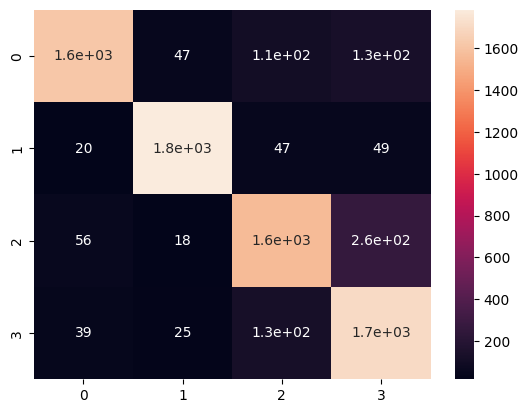

In [93]:
sns.heatmap(confusion_matrix,annot=True)

Random Weights

In [96]:
class ElmoClassifier_rand(torch.nn.Module):
    def __init__(self,no_classes,elmo,in_features,embedding_dim):
        super(ElmoClassifier_rand,self).__init__()
        self.pretrainedmodel=elmo
        self.linear1=nn.Linear(in_features,no_classes)
        self.param0=nn.Parameter(torch.rand(1),requires_grad=False)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=False)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=False)
        self.bilstm=nn.LSTM(input_size=embedding_dim,hidden_size=200,bidirectional=True,batch_first=True)
        self.softmax=torch.nn.Softmax()
    def forward(self,embdata):
        #print(embdata.shape)
        _,word_emb,h1,h2=self.pretrainedmodel(embdata)
        #print(word_emb.shape)
        out=self.softmax(torch.tensor([self.param0,self.param1,self.param2]))
        #print(outputfrompretrained.shape)
        bio,bih=self.bilstm(out[0]*word_emb+out[1]*h1+out[2]*h2)
        #print(bio.shape)
        y=self.linear1(bio[:,-1,:])
        #print(y.shape)
        return y

In [97]:
classifier_rand=ElmoClassifier_rand(4,md5,400,200)
classifier_rand.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier_rand.parameters(),1e-3)

In [99]:
torch.cuda.empty_cache()
gc.collect()

3517

In [101]:
for epoch in range(10):
    train_loss=0
    classifier_rand.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()
          #print('train',x_train.shape)
          #x_train.to(device)
          #y_train.to(device)
        output=classifier_rand(x_train.to(device))
        loss=loss_fn(output,y_train.view(-1).to(device))
          #print(output.shape)
        del output
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)

Training:   0%|          | 0/1875 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [04:27<00:00,  7.00it/s]


1761.5592359900475


Training: 100%|██████████| 1875/1875 [04:27<00:00,  7.00it/s]


868.7618119865656


Training: 100%|██████████| 1875/1875 [04:27<00:00,  7.00it/s]


670.6302999556065


Training: 100%|██████████| 1875/1875 [04:27<00:00,  7.00it/s]


573.7738812640309


Training: 100%|██████████| 1875/1875 [04:27<00:00,  7.00it/s]


510.40297993272543


Training: 100%|██████████| 1875/1875 [04:28<00:00,  6.98it/s]


457.75380647182465


Training: 100%|██████████| 1875/1875 [04:28<00:00,  6.99it/s]


418.0860716588795


Training: 100%|██████████| 1875/1875 [04:28<00:00,  6.99it/s]


383.19885922409594


Training: 100%|██████████| 1875/1875 [04:28<00:00,  6.99it/s]


354.361365608871


Training: 100%|██████████| 1875/1875 [04:28<00:00,  6.99it/s]

327.04549665376544


In [102]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((4,4))
classifier_rand.eval()
y_true=[]
y_pred=[]
train_loss=0.0
for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
    classifier_rand.eval()
    with torch.no_grad():
        x_train,y_train=batch
        optimizer.zero_grad()
            #print('train',x_train.shape)
            #print(y_train)
        #x_train.to(device)
        #y_train.to(device)
        output=classifier_rand(x_train.to(device))
        _,preds=torch.max(output,dim=1)
        y_true.extend(y_train.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        train_loss +=loss.item()
        print(train_loss)
        for i in range(len(y_train)):
            confusion_matrix[y_train[i]][preds[i]]+=1

Evaluation:   1%|          | 1/119 [00:00<00:13,  8.55it/s]

0.028146907687187195


Evaluation:   2%|▏         | 2/119 [00:00<00:13,  8.55it/s]

0.05629381537437439


Evaluation:   3%|▎         | 3/119 [00:00<00:13,  8.54it/s]

0.08444072306156158


Evaluation:   3%|▎         | 4/119 [00:00<00:13,  8.55it/s]

0.11258763074874878


Evaluation:   4%|▍         | 5/119 [00:00<00:13,  8.55it/s]

0.14073453843593597


Evaluation:   5%|▌         | 6/119 [00:00<00:13,  8.55it/s]

0.16888144612312317


Evaluation:   6%|▌         | 7/119 [00:00<00:13,  8.55it/s]

0.19702835381031036


Evaluation:   7%|▋         | 8/119 [00:00<00:12,  8.54it/s]

0.22517526149749756


Evaluation:   8%|▊         | 9/119 [00:01<00:12,  8.54it/s]

0.25332216918468475


Evaluation:   8%|▊         | 10/119 [00:01<00:12,  8.54it/s]

0.28146907687187195


Evaluation:   9%|▉         | 11/119 [00:01<00:12,  8.54it/s]

0.30961598455905914


Evaluation:  10%|█         | 12/119 [00:01<00:12,  8.54it/s]

0.33776289224624634


Evaluation:  11%|█         | 13/119 [00:01<00:12,  8.55it/s]

0.36590979993343353


Evaluation:  12%|█▏        | 14/119 [00:01<00:12,  8.55it/s]

0.3940567076206207


Evaluation:  13%|█▎        | 15/119 [00:01<00:12,  8.55it/s]

0.4222036153078079


Evaluation:  13%|█▎        | 16/119 [00:01<00:12,  8.55it/s]

0.4503505229949951


Evaluation:  14%|█▍        | 17/119 [00:01<00:11,  8.55it/s]

0.4784974306821823


Evaluation:  15%|█▌        | 18/119 [00:02<00:11,  8.54it/s]

0.5066443383693695


Evaluation:  16%|█▌        | 19/119 [00:02<00:11,  8.55it/s]

0.5347912460565567


Evaluation:  17%|█▋        | 20/119 [00:02<00:11,  8.54it/s]

0.5629381537437439


Evaluation:  18%|█▊        | 21/119 [00:02<00:11,  8.54it/s]

0.5910850614309311


Evaluation:  18%|█▊        | 22/119 [00:02<00:11,  8.53it/s]

0.6192319691181183


Evaluation:  19%|█▉        | 23/119 [00:02<00:11,  8.53it/s]

0.6473788768053055


Evaluation:  20%|██        | 24/119 [00:02<00:11,  8.53it/s]

0.6755257844924927


Evaluation:  21%|██        | 25/119 [00:02<00:11,  8.53it/s]

0.7036726921796799


Evaluation:  22%|██▏       | 26/119 [00:03<00:10,  8.54it/s]

0.7318195998668671


Evaluation:  23%|██▎       | 27/119 [00:03<00:10,  8.53it/s]

0.7599665075540543


Evaluation:  24%|██▎       | 28/119 [00:03<00:10,  8.53it/s]

0.7881134152412415


Evaluation:  24%|██▍       | 29/119 [00:03<00:10,  8.53it/s]

0.8162603229284286


Evaluation:  25%|██▌       | 30/119 [00:03<00:10,  8.52it/s]

0.8444072306156158


Evaluation:  26%|██▌       | 31/119 [00:03<00:10,  8.52it/s]

0.872554138302803


Evaluation:  27%|██▋       | 32/119 [00:03<00:10,  8.53it/s]

0.9007010459899902


Evaluation:  28%|██▊       | 33/119 [00:03<00:10,  8.54it/s]

0.9288479536771774


Evaluation:  29%|██▊       | 34/119 [00:03<00:09,  8.54it/s]

0.9569948613643646


Evaluation:  29%|██▉       | 35/119 [00:04<00:09,  8.55it/s]

0.9851417690515518


Evaluation:  30%|███       | 36/119 [00:04<00:09,  8.53it/s]

1.013288676738739


Evaluation:  31%|███       | 37/119 [00:04<00:09,  8.53it/s]

1.0414355844259262


Evaluation:  32%|███▏      | 38/119 [00:04<00:09,  8.53it/s]

1.0695824921131134


Evaluation:  33%|███▎      | 39/119 [00:04<00:09,  8.54it/s]

1.0977293998003006


Evaluation:  34%|███▎      | 40/119 [00:04<00:09,  8.53it/s]

1.1258763074874878


Evaluation:  34%|███▍      | 41/119 [00:04<00:09,  8.54it/s]

1.154023215174675


Evaluation:  35%|███▌      | 42/119 [00:04<00:09,  8.54it/s]

1.1821701228618622


Evaluation:  36%|███▌      | 43/119 [00:05<00:08,  8.54it/s]

1.2103170305490494


Evaluation:  37%|███▋      | 44/119 [00:05<00:08,  8.55it/s]

1.2384639382362366


Evaluation:  38%|███▊      | 45/119 [00:05<00:08,  8.53it/s]

1.2666108459234238


Evaluation:  39%|███▊      | 46/119 [00:05<00:08,  8.53it/s]

1.294757753610611


Evaluation:  39%|███▉      | 47/119 [00:05<00:08,  8.52it/s]

1.3229046612977982


Evaluation:  40%|████      | 48/119 [00:05<00:08,  8.52it/s]

1.3510515689849854


Evaluation:  41%|████      | 49/119 [00:05<00:08,  8.52it/s]

1.3791984766721725


Evaluation:  42%|████▏     | 50/119 [00:05<00:08,  8.53it/s]

1.4073453843593597


Evaluation:  43%|████▎     | 51/119 [00:05<00:07,  8.53it/s]

1.435492292046547


Evaluation:  44%|████▎     | 52/119 [00:06<00:07,  8.53it/s]

1.4636391997337341


Evaluation:  45%|████▍     | 53/119 [00:06<00:07,  8.53it/s]

1.4917861074209213


Evaluation:  45%|████▌     | 54/119 [00:06<00:07,  8.53it/s]

1.5199330151081085


Evaluation:  46%|████▌     | 55/119 [00:06<00:07,  8.53it/s]

1.5480799227952957


Evaluation:  47%|████▋     | 56/119 [00:06<00:07,  8.53it/s]

1.576226830482483


Evaluation:  48%|████▊     | 57/119 [00:06<00:07,  8.52it/s]

1.60437373816967


Evaluation:  49%|████▊     | 58/119 [00:06<00:07,  8.51it/s]

1.6325206458568573


Evaluation:  50%|████▉     | 59/119 [00:06<00:07,  8.51it/s]

1.6606675535440445


Evaluation:  50%|█████     | 60/119 [00:07<00:06,  8.52it/s]

1.6888144612312317


Evaluation:  51%|█████▏    | 61/119 [00:07<00:06,  8.52it/s]

1.7169613689184189


Evaluation:  52%|█████▏    | 62/119 [00:07<00:06,  8.50it/s]

1.745108276605606


Evaluation:  53%|█████▎    | 63/119 [00:07<00:06,  8.52it/s]

1.7732551842927933


Evaluation:  54%|█████▍    | 64/119 [00:07<00:06,  8.53it/s]

1.8014020919799805


Evaluation:  55%|█████▍    | 65/119 [00:07<00:06,  8.54it/s]

1.8295489996671677


Evaluation:  55%|█████▌    | 66/119 [00:07<00:06,  8.55it/s]

1.8576959073543549


Evaluation:  56%|█████▋    | 67/119 [00:07<00:06,  8.56it/s]

1.885842815041542


Evaluation:  57%|█████▋    | 68/119 [00:07<00:05,  8.57it/s]

1.9139897227287292


Evaluation:  58%|█████▊    | 69/119 [00:08<00:05,  8.57it/s]

1.9421366304159164


Evaluation:  59%|█████▉    | 70/119 [00:08<00:05,  8.57it/s]

1.9702835381031036


Evaluation:  60%|█████▉    | 71/119 [00:08<00:05,  8.57it/s]

1.9984304457902908


Evaluation:  61%|██████    | 72/119 [00:08<00:05,  8.57it/s]

2.026577353477478


Evaluation:  61%|██████▏   | 73/119 [00:08<00:05,  8.57it/s]

2.0547242611646652


Evaluation:  62%|██████▏   | 74/119 [00:08<00:05,  8.58it/s]

2.0828711688518524


Evaluation:  63%|██████▎   | 75/119 [00:08<00:05,  8.58it/s]

2.1110180765390396


Evaluation:  64%|██████▍   | 76/119 [00:08<00:05,  8.58it/s]

2.139164984226227


Evaluation:  65%|██████▍   | 77/119 [00:09<00:04,  8.58it/s]

2.167311891913414


Evaluation:  66%|██████▌   | 78/119 [00:09<00:04,  8.58it/s]

2.195458799600601


Evaluation:  66%|██████▋   | 79/119 [00:09<00:04,  8.58it/s]

2.2236057072877884


Evaluation:  67%|██████▋   | 80/119 [00:09<00:04,  8.57it/s]

2.2517526149749756


Evaluation:  68%|██████▊   | 81/119 [00:09<00:04,  8.57it/s]

2.279899522662163


Evaluation:  69%|██████▉   | 82/119 [00:09<00:04,  8.57it/s]

2.30804643034935


Evaluation:  70%|██████▉   | 83/119 [00:09<00:04,  8.57it/s]

2.336193338036537


Evaluation:  71%|███████   | 84/119 [00:09<00:04,  8.57it/s]

2.3643402457237244


Evaluation:  71%|███████▏  | 85/119 [00:09<00:03,  8.56it/s]

2.3924871534109116


Evaluation:  72%|███████▏  | 86/119 [00:10<00:03,  8.55it/s]

2.4206340610980988


Evaluation:  73%|███████▎  | 87/119 [00:10<00:03,  8.55it/s]

2.448780968785286


Evaluation:  74%|███████▍  | 88/119 [00:10<00:03,  8.55it/s]

2.476927876472473


Evaluation:  75%|███████▍  | 89/119 [00:10<00:03,  8.55it/s]

2.5050747841596603


Evaluation:  76%|███████▌  | 90/119 [00:10<00:03,  8.55it/s]

2.5332216918468475


Evaluation:  76%|███████▋  | 91/119 [00:10<00:03,  8.55it/s]

2.5613685995340347


Evaluation:  77%|███████▋  | 92/119 [00:10<00:03,  8.56it/s]

2.589515507221222


Evaluation:  78%|███████▊  | 93/119 [00:10<00:03,  8.56it/s]

2.617662414908409


Evaluation:  79%|███████▉  | 94/119 [00:11<00:02,  8.56it/s]

2.6458093225955963


Evaluation:  80%|███████▉  | 95/119 [00:11<00:02,  8.57it/s]

2.6739562302827835


Evaluation:  81%|████████  | 96/119 [00:11<00:02,  8.57it/s]

2.7021031379699707


Evaluation:  82%|████████▏ | 97/119 [00:11<00:02,  8.57it/s]

2.730250045657158


Evaluation:  82%|████████▏ | 98/119 [00:11<00:02,  8.57it/s]

2.758396953344345


Evaluation:  83%|████████▎ | 99/119 [00:11<00:02,  8.57it/s]

2.7865438610315323


Evaluation:  84%|████████▍ | 100/119 [00:11<00:02,  8.57it/s]

2.8146907687187195


Evaluation:  85%|████████▍ | 101/119 [00:11<00:02,  8.57it/s]

2.8428376764059067


Evaluation:  86%|████████▌ | 102/119 [00:11<00:01,  8.58it/s]

2.870984584093094


Evaluation:  87%|████████▋ | 103/119 [00:12<00:01,  8.58it/s]

2.899131491780281


Evaluation:  87%|████████▋ | 104/119 [00:12<00:01,  8.56it/s]

2.9272783994674683


Evaluation:  88%|████████▊ | 105/119 [00:12<00:01,  8.56it/s]

2.9554253071546555


Evaluation:  89%|████████▉ | 106/119 [00:12<00:01,  8.56it/s]

2.9835722148418427


Evaluation:  90%|████████▉ | 107/119 [00:12<00:01,  8.57it/s]

3.01171912252903


Evaluation:  91%|█████████ | 108/119 [00:12<00:01,  8.56it/s]

3.039866030216217


Evaluation:  92%|█████████▏| 109/119 [00:12<00:01,  8.57it/s]

3.0680129379034042


Evaluation:  92%|█████████▏| 110/119 [00:12<00:01,  8.57it/s]

3.0961598455905914


Evaluation:  93%|█████████▎| 111/119 [00:12<00:00,  8.57it/s]

3.1243067532777786


Evaluation:  94%|█████████▍| 112/119 [00:13<00:00,  8.58it/s]

3.152453660964966


Evaluation:  95%|█████████▍| 113/119 [00:13<00:00,  8.58it/s]

3.180600568652153


Evaluation:  96%|█████████▌| 114/119 [00:13<00:00,  8.59it/s]

3.20874747633934


Evaluation:  97%|█████████▋| 115/119 [00:13<00:00,  8.58it/s]

3.2368943840265274


Evaluation:  97%|█████████▋| 116/119 [00:13<00:00,  8.57it/s]

3.2650412917137146


Evaluation:  98%|█████████▊| 117/119 [00:13<00:00,  8.57it/s]

3.293188199400902


Evaluation:  99%|█████████▉| 118/119 [00:13<00:00,  8.57it/s]

3.321335107088089


Evaluation: 100%|██████████| 119/119 [00:13<00:00,  8.57it/s]

3.349482014775276


[[1673.   76.   82.   69.]
 [  26. 1830.   25.   19.]
 [  59.   46. 1615.  180.]
 [  80.   40.  187. 1593.]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1900
           1       0.92      0.96      0.94      1900
           2       0.85      0.85      0.85      1900
           3       0.86      0.84      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



<Axes: >

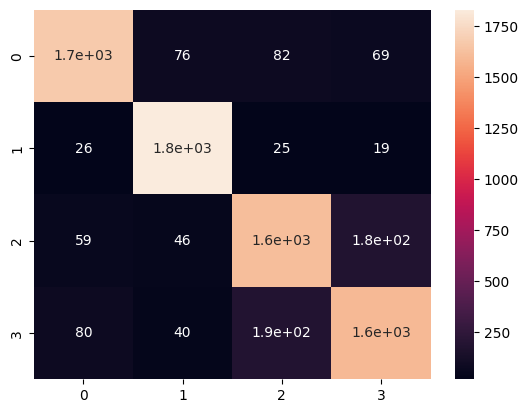

In [103]:
print(confusion_matrix)
print(classification_report(y_true,y_pred))
sns.heatmap(confusion_matrix,annot=True)

In [104]:
torch.save(classifier_rand,'/kaggle/working/classifierrand')

from IPython.display import FileLink
FileLink(r'/kaggle/working/classifierrand')

/kaggle/working/classifierrand

Function Learning

In [105]:
class ElmoClassifier_rand_f(torch.nn.Module):
    def __init__(self,no_classes,elmo,in_features,embedding_dim):
        super(ElmoClassifier_rand_f,self).__init__()
        self.pretrainedmodel=elmo
        self.linear1=nn.Linear(in_features,no_classes)
        self.param0=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param1=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param2=nn.Parameter(torch.rand(1),requires_grad=True)
        self.param3=nn.Parameter(torch.rand(1),requires_grad=True)
        self.bilstm=nn.LSTM(input_size=embedding_dim,hidden_size=200,bidirectional=True,batch_first=True)
        self.softmax=torch.nn.Softmax()
        self.relu=torch.nn.ReLU()
    def forward(self,embdata):
        #print(embdata.shape)
        _,word_emb,h1,h2=self.pretrainedmodel(embdata)
        #print(word_emb.shape)
        out=self.softmax(torch.tensor([self.param0,self.param1,self.param2]))
        #print(outputfrompretrained.shape)
        bio,bih=self.bilstm(self.relu((out[0]*word_emb+out[1]*h1+out[2]*h2),self.param3))
        #print(bio.shape)
        y=self.linear1(bio[:,-1,:])
        #print(y.shape)
        return y

Training:   0%|          | 0/1875 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


2225.9104103446007


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.02it/s]


1172.5852410197258


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


789.7089897319674


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


654.7294551730156


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.04it/s]


571.2019198387861


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.04it/s]


509.3986274264753


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


459.3004419282079


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


415.8361667096615


Training: 100%|██████████| 1875/1875 [04:27<00:00,  7.02it/s]


377.9841889925301


Training: 100%|██████████| 1875/1875 [04:26<00:00,  7.03it/s]


348.12383027374744


Evaluation:   1%|          | 1/119 [00:00<00:13,  8.51it/s]

0.3474261164665222


Evaluation:   2%|▏         | 2/119 [00:00<00:13,  8.52it/s]

0.6948522329330444


Evaluation:   3%|▎         | 3/119 [00:00<00:13,  8.55it/s]

1.0422783493995667


Evaluation:   3%|▎         | 4/119 [00:00<00:13,  8.56it/s]

1.3897044658660889


Evaluation:   4%|▍         | 5/119 [00:00<00:13,  8.55it/s]

1.737130582332611


Evaluation:   5%|▌         | 6/119 [00:00<00:13,  8.55it/s]

2.0845566987991333


Evaluation:   6%|▌         | 7/119 [00:00<00:13,  8.55it/s]

2.4319828152656555


Evaluation:   7%|▋         | 8/119 [00:00<00:12,  8.54it/s]

2.7794089317321777


Evaluation:   8%|▊         | 9/119 [00:01<00:12,  8.49it/s]

3.1268350481987


Evaluation:   8%|▊         | 10/119 [00:01<00:12,  8.48it/s]

3.474261164665222


Evaluation:   9%|▉         | 11/119 [00:01<00:12,  8.48it/s]

3.8216872811317444


Evaluation:  10%|█         | 12/119 [00:01<00:12,  8.49it/s]

4.169113397598267


Evaluation:  11%|█         | 13/119 [00:01<00:12,  8.50it/s]

4.516539514064789


Evaluation:  12%|█▏        | 14/119 [00:01<00:12,  8.51it/s]

4.863965630531311


Evaluation:  13%|█▎        | 15/119 [00:01<00:12,  8.51it/s]

5.211391746997833


Evaluation:  13%|█▎        | 16/119 [00:01<00:12,  8.49it/s]

5.5588178634643555


Evaluation:  14%|█▍        | 17/119 [00:01<00:11,  8.51it/s]

5.906243979930878


Evaluation:  15%|█▌        | 18/119 [00:02<00:11,  8.51it/s]

6.2536700963974


Evaluation:  16%|█▌        | 19/119 [00:02<00:11,  8.52it/s]

6.601096212863922


Evaluation:  17%|█▋        | 20/119 [00:02<00:11,  8.52it/s]

6.948522329330444


Evaluation:  18%|█▊        | 21/119 [00:02<00:11,  8.53it/s]

7.2959484457969666


Evaluation:  18%|█▊        | 22/119 [00:02<00:11,  8.53it/s]

7.643374562263489


Evaluation:  19%|█▉        | 23/119 [00:02<00:11,  8.53it/s]

7.990800678730011


Evaluation:  20%|██        | 24/119 [00:02<00:11,  8.53it/s]

8.338226795196533


Evaluation:  21%|██        | 25/119 [00:02<00:11,  8.53it/s]

8.685652911663055


Evaluation:  22%|██▏       | 26/119 [00:03<00:10,  8.54it/s]

9.033079028129578


Evaluation:  23%|██▎       | 27/119 [00:03<00:10,  8.53it/s]

9.3805051445961


Evaluation:  24%|██▎       | 28/119 [00:03<00:10,  8.54it/s]

9.727931261062622


Evaluation:  24%|██▍       | 29/119 [00:03<00:10,  8.54it/s]

10.075357377529144


Evaluation:  25%|██▌       | 30/119 [00:03<00:10,  8.54it/s]

10.422783493995667


Evaluation:  26%|██▌       | 31/119 [00:03<00:10,  8.54it/s]

10.770209610462189


Evaluation:  27%|██▋       | 32/119 [00:03<00:10,  8.55it/s]

11.117635726928711


Evaluation:  28%|██▊       | 33/119 [00:03<00:10,  8.55it/s]

11.465061843395233


Evaluation:  29%|██▊       | 34/119 [00:03<00:09,  8.54it/s]

11.812487959861755


Evaluation:  29%|██▉       | 35/119 [00:04<00:09,  8.55it/s]

12.159914076328278


Evaluation:  30%|███       | 36/119 [00:04<00:09,  8.54it/s]

12.5073401927948


Evaluation:  31%|███       | 37/119 [00:04<00:09,  8.54it/s]

12.854766309261322


Evaluation:  32%|███▏      | 38/119 [00:04<00:09,  8.52it/s]

13.202192425727844


Evaluation:  33%|███▎      | 39/119 [00:04<00:09,  8.48it/s]

13.549618542194366


Evaluation:  34%|███▎      | 40/119 [00:04<00:09,  8.49it/s]

13.897044658660889


Evaluation:  34%|███▍      | 41/119 [00:04<00:09,  8.50it/s]

14.244470775127411


Evaluation:  35%|███▌      | 42/119 [00:04<00:09,  8.52it/s]

14.591896891593933


Evaluation:  36%|███▌      | 43/119 [00:05<00:08,  8.52it/s]

14.939323008060455


Evaluation:  37%|███▋      | 44/119 [00:05<00:08,  8.53it/s]

15.286749124526978


Evaluation:  38%|███▊      | 45/119 [00:05<00:08,  8.53it/s]

15.6341752409935


Evaluation:  39%|███▊      | 46/119 [00:05<00:08,  8.53it/s]

15.981601357460022


Evaluation:  39%|███▉      | 47/119 [00:05<00:08,  8.55it/s]

16.329027473926544


Evaluation:  40%|████      | 48/119 [00:05<00:08,  8.56it/s]

16.676453590393066


Evaluation:  41%|████      | 49/119 [00:05<00:08,  8.56it/s]

17.02387970685959


Evaluation:  42%|████▏     | 50/119 [00:05<00:08,  8.57it/s]

17.37130582332611


Evaluation:  43%|████▎     | 51/119 [00:05<00:07,  8.57it/s]

17.718731939792633


Evaluation:  44%|████▎     | 52/119 [00:06<00:07,  8.56it/s]

18.066158056259155


Evaluation:  45%|████▍     | 53/119 [00:06<00:07,  8.57it/s]

18.413584172725677


Evaluation:  45%|████▌     | 54/119 [00:06<00:07,  8.56it/s]

18.7610102891922


Evaluation:  46%|████▌     | 55/119 [00:06<00:07,  8.56it/s]

19.108436405658722


Evaluation:  47%|████▋     | 56/119 [00:06<00:07,  8.55it/s]

19.455862522125244


Evaluation:  48%|████▊     | 57/119 [00:06<00:07,  8.54it/s]

19.803288638591766


Evaluation:  49%|████▊     | 58/119 [00:06<00:07,  8.54it/s]

20.15071475505829


Evaluation:  50%|████▉     | 59/119 [00:06<00:07,  8.53it/s]

20.49814087152481


Evaluation:  50%|█████     | 60/119 [00:07<00:06,  8.54it/s]

20.845566987991333


Evaluation:  51%|█████▏    | 61/119 [00:07<00:06,  8.55it/s]

21.192993104457855


Evaluation:  52%|█████▏    | 62/119 [00:07<00:06,  8.55it/s]

21.540419220924377


Evaluation:  53%|█████▎    | 63/119 [00:07<00:06,  8.56it/s]

21.8878453373909


Evaluation:  54%|█████▍    | 64/119 [00:07<00:06,  8.56it/s]

22.235271453857422


Evaluation:  55%|█████▍    | 65/119 [00:07<00:06,  8.57it/s]

22.582697570323944


Evaluation:  55%|█████▌    | 66/119 [00:07<00:06,  8.56it/s]

22.930123686790466


Evaluation:  56%|█████▋    | 67/119 [00:07<00:06,  8.56it/s]

23.27754980325699


Evaluation:  57%|█████▋    | 68/119 [00:07<00:05,  8.56it/s]

23.62497591972351


Evaluation:  58%|█████▊    | 69/119 [00:08<00:05,  8.57it/s]

23.972402036190033


Evaluation:  59%|█████▉    | 70/119 [00:08<00:05,  8.57it/s]

24.319828152656555


Evaluation:  60%|█████▉    | 71/119 [00:08<00:05,  8.57it/s]

24.667254269123077


Evaluation:  61%|██████    | 72/119 [00:08<00:05,  8.57it/s]

25.0146803855896


Evaluation:  61%|██████▏   | 73/119 [00:08<00:05,  8.56it/s]

25.362106502056122


Evaluation:  62%|██████▏   | 74/119 [00:08<00:05,  8.56it/s]

25.709532618522644


Evaluation:  63%|██████▎   | 75/119 [00:08<00:05,  8.56it/s]

26.056958734989166


Evaluation:  64%|██████▍   | 76/119 [00:08<00:05,  8.57it/s]

26.40438485145569


Evaluation:  65%|██████▍   | 77/119 [00:09<00:04,  8.56it/s]

26.75181096792221


Evaluation:  66%|██████▌   | 78/119 [00:09<00:04,  8.56it/s]

27.099237084388733


Evaluation:  66%|██████▋   | 79/119 [00:09<00:04,  8.57it/s]

27.446663200855255


Evaluation:  67%|██████▋   | 80/119 [00:09<00:04,  8.57it/s]

27.794089317321777


Evaluation:  68%|██████▊   | 81/119 [00:09<00:04,  8.57it/s]

28.1415154337883


Evaluation:  69%|██████▉   | 82/119 [00:09<00:04,  8.57it/s]

28.488941550254822


Evaluation:  70%|██████▉   | 83/119 [00:09<00:04,  8.57it/s]

28.836367666721344


Evaluation:  71%|███████   | 84/119 [00:09<00:04,  8.57it/s]

29.183793783187866


Evaluation:  71%|███████▏  | 85/119 [00:09<00:03,  8.57it/s]

29.53121989965439


Evaluation:  72%|███████▏  | 86/119 [00:10<00:03,  8.57it/s]

29.87864601612091


Evaluation:  73%|███████▎  | 87/119 [00:10<00:03,  8.57it/s]

30.226072132587433


Evaluation:  74%|███████▍  | 88/119 [00:10<00:03,  8.57it/s]

30.573498249053955


Evaluation:  75%|███████▍  | 89/119 [00:10<00:03,  8.57it/s]

30.920924365520477


Evaluation:  76%|███████▌  | 90/119 [00:10<00:03,  8.56it/s]

31.268350481987


Evaluation:  76%|███████▋  | 91/119 [00:10<00:03,  8.56it/s]

31.61577659845352


Evaluation:  77%|███████▋  | 92/119 [00:10<00:03,  8.56it/s]

31.963202714920044


Evaluation:  78%|███████▊  | 93/119 [00:10<00:03,  8.56it/s]

32.310628831386566


Evaluation:  79%|███████▉  | 94/119 [00:11<00:02,  8.56it/s]

32.65805494785309


Evaluation:  80%|███████▉  | 95/119 [00:11<00:02,  8.55it/s]

33.00548106431961


Evaluation:  81%|████████  | 96/119 [00:11<00:02,  8.55it/s]

33.35290718078613


Evaluation:  82%|████████▏ | 97/119 [00:11<00:02,  8.56it/s]

33.700333297252655


Evaluation:  82%|████████▏ | 98/119 [00:11<00:02,  8.57it/s]

34.04775941371918


Evaluation:  83%|████████▎ | 99/119 [00:11<00:02,  8.57it/s]

34.3951855301857


Evaluation:  84%|████████▍ | 100/119 [00:11<00:02,  8.57it/s]

34.74261164665222


Evaluation:  85%|████████▍ | 101/119 [00:11<00:02,  8.57it/s]

35.090037763118744


Evaluation:  86%|████████▌ | 102/119 [00:11<00:01,  8.56it/s]

35.437463879585266


Evaluation:  87%|████████▋ | 103/119 [00:12<00:01,  8.56it/s]

35.78488999605179


Evaluation:  87%|████████▋ | 104/119 [00:12<00:01,  8.56it/s]

36.13231611251831


Evaluation:  88%|████████▊ | 105/119 [00:12<00:01,  8.57it/s]

36.47974222898483


Evaluation:  89%|████████▉ | 106/119 [00:12<00:01,  8.57it/s]

36.827168345451355


Evaluation:  90%|████████▉ | 107/119 [00:12<00:01,  8.57it/s]

37.17459446191788


Evaluation:  91%|█████████ | 108/119 [00:12<00:01,  8.57it/s]

37.5220205783844


Evaluation:  92%|█████████▏| 109/119 [00:12<00:01,  8.57it/s]

37.86944669485092


Evaluation:  92%|█████████▏| 110/119 [00:12<00:01,  8.57it/s]

38.216872811317444


Evaluation:  93%|█████████▎| 111/119 [00:12<00:00,  8.57it/s]

38.564298927783966


Evaluation:  94%|█████████▍| 112/119 [00:13<00:00,  8.57it/s]

38.91172504425049


Evaluation:  95%|█████████▍| 113/119 [00:13<00:00,  8.57it/s]

39.25915116071701


Evaluation:  96%|█████████▌| 114/119 [00:13<00:00,  8.57it/s]

39.60657727718353


Evaluation:  97%|█████████▋| 115/119 [00:13<00:00,  8.58it/s]

39.954003393650055


Evaluation:  97%|█████████▋| 116/119 [00:13<00:00,  8.58it/s]

40.30142951011658


Evaluation:  98%|█████████▊| 117/119 [00:13<00:00,  8.57it/s]

40.6488556265831


Evaluation:  99%|█████████▉| 118/119 [00:13<00:00,  8.57it/s]

40.99628174304962


Evaluation: 100%|██████████| 119/119 [00:13<00:00,  8.57it/s]

41.343707859516144
[[1674.   58.   93.   75.]
 [  27. 1811.   28.   34.]
 [  63.   22. 1593.  222.]
 [  54.   26.  169. 1651.]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1900
           1       0.94      0.95      0.95      1900
           2       0.85      0.84      0.84      1900
           3       0.83      0.87      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



<Axes: >

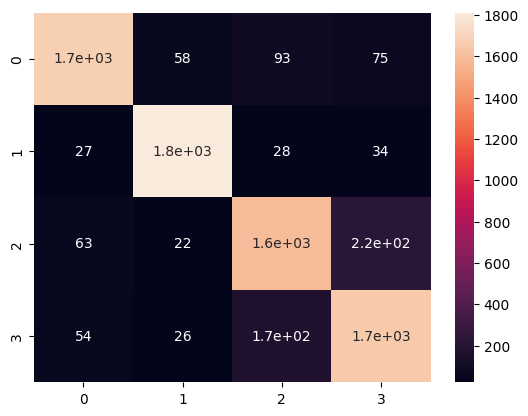

In [106]:
classifier_rand_f=ElmoClassifier_rand_f(4,md5,400,200)
classifier_rand_f.to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(classifier_rand_f.parameters(),1e-3)
torch.cuda.empty_cache()
gc.collect()
for epoch in range(10):
    train_loss=0
    classifier_rand_f.train()
    for batch in tqdm(classifer_dataloader,desc="Training"):
        x_train,y_train=batch
        optimizer.zero_grad()
          #print('train',x_train.shape)
          #x_train.to(device)
          #y_train.to(device)
        output=classifier_rand_f(x_train.to(device))
        loss=loss_fn(output,y_train.view(-1).to(device))
          #print(output.shape)
        del output
        loss.backward()
        optimizer.step()
        train_loss +=loss.item()
    print(train_loss)
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,recall_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
confusion_matrix=np.zeros((4,4))
classifier_rand_f.eval()
y_true=[]
y_pred=[]
train_loss=0.0
for batch in tqdm(classifer_dataloader_eval,desc="Evaluation"):
    classifier_rand_f.eval()
    with torch.no_grad():
        x_train,y_train=batch
        optimizer.zero_grad()
            #print('train',x_train.shape)
            #print(y_train)
        #x_train.to(device)
        #y_train.to(device)
        output=classifier_rand_f(x_train.to(device))
        _,preds=torch.max(output,dim=1)
        y_true.extend(y_train.cpu().detach().numpy())
        y_pred.extend(preds.cpu().detach().numpy())
        train_loss +=loss.item()
        print(train_loss)
        for i in range(len(y_train)):
            confusion_matrix[y_train[i]][preds[i]]+=1
print(confusion_matrix)
print(classification_report(y_true,y_pred))
sns.heatmap(confusion_matrix,annot=True)

In [107]:
torch.save(classifier_rand_f,'/kaggle/working/classifierrandf')

from IPython.display import FileLink
FileLink(r'/kaggle/working/classifierrandf')

/kaggle/working/classifierrandf